# 导入依赖包

In [7]:
import pandas as pd
import csv
import numpy as np
from amp.utils import basic_model_serializer
import amp.data_utils.sequence as du_sequence
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# 加载模型

In [8]:
bms = basic_model_serializer.BasicModelSerializer()
amp_classifier = bms.load_model('models/amp_classifier')
amp_classifier_model = amp_classifier()
mic_classifier = bms.load_model('models/mic_classifier/')
mic_classifier_model = mic_classifier() 

/geniusland/home/xiaoliwei/anaconda3/envs/new_fg_ds/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# 加载数据

In [9]:
from bio_utils import *

def get_peps(epoch):
    data_file = "/geniusland/home/xiaoliwei/seqgan_xlw/samples/basic_peps/adv_{}.txt".format(epoch)
    with open(data_file, 'r') as f:
        lines = f.readlines()

    p_seqs = []
    for line in lines:
        p_seq = ""
        flag = 1
        if line[0] != 'M': continue
        for i in range(1, len(line)):
            codon = line[i]
            try:
                p_seq += codon
                if codon == '*': break
                if codon == '#': break
                if codon == '\n':break
            except:
                flag = 0
                break
        if len(p_seq) <= 1 or len(p_seq) >= 26:
            flag = 0
        elif p_seq[-1] != '*':
            flag = 0
        
        if flag:
            p_seqs.append(p_seq[:-2])
    return p_seqs

dict = {"sequence": get_peps(120)}
data = pd.DataFrame(dict)
# 准备自己的数据
# data = pd.read_csv('/geniusland/home/xiaoliwei/seqgan_xlw/samples/basic/amp_test.csv')
seq_list = np.array(data.sequence.tolist()).squeeze().tolist()
pad_seq = du_sequence.pad(du_sequence.to_one_hot(seq_list))

# 预测

In [10]:
pred_amp = amp_classifier_model.predict(pad_seq)
pred_mic = mic_classifier_model.predict(pad_seq)

145/145 [==============================] - 1s 4ms/step


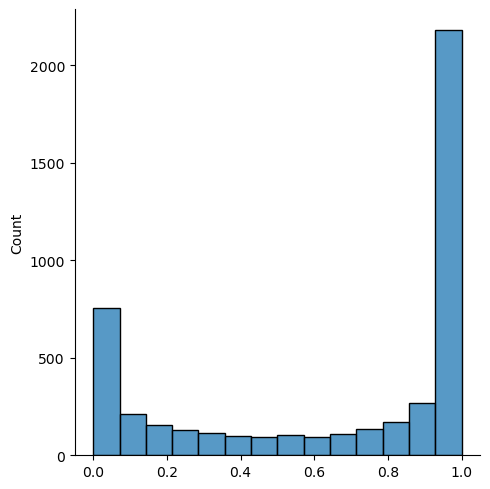

<Figure size 640x480 with 0 Axes>

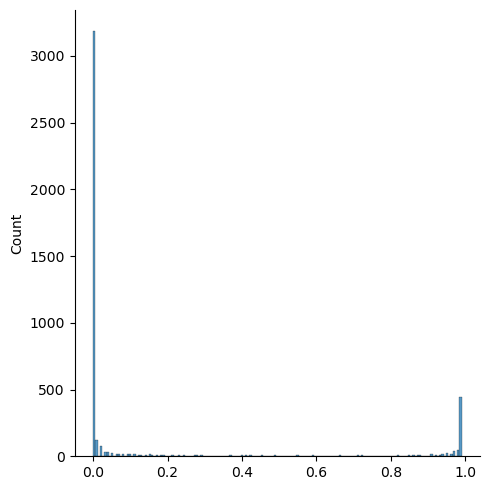

In [11]:
import numpy as np
np.set_printoptions(suppress=True, threshold=np.inf)

static_amp = []
for amp in pred_amp:
    temp = amp * 100
    temp = int(temp)
    temp = temp / 100
    static_amp.append(temp)

static_mic = []
for mic in pred_mic:
    temp = mic * 100
    temp = int(temp)
    temp = temp / 100
    static_mic.append(temp)

import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data = static_amp)
plt.figure()
sns.displot(data = static_mic)

176/176 [==============================] - 1s 7ms/step


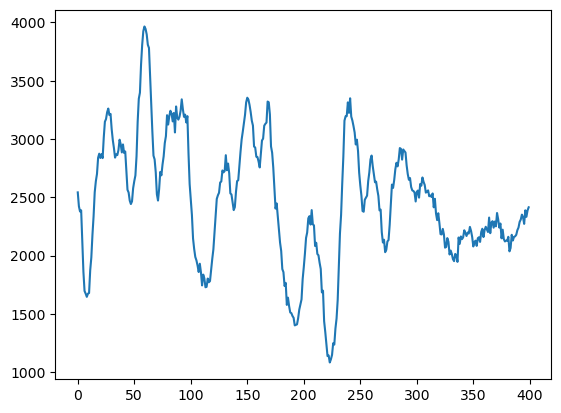

In [14]:
from collections import Counter

list_95 = []
list_all = []
for i in range(0, 400):
    dict = {"sequence": get_peps(i)}
    data = pd.DataFrame(dict)
    # 准备自己的数据
    # data = pd.read_csv('/geniusland/home/xiaoliwei/seqgan_xlw/samples/basic/amp_test.csv')
    seq_list = np.array(data.sequence.tolist()).squeeze().tolist()
    pad_seq = du_sequence.pad(du_sequence.to_one_hot(seq_list))

    pred_amp = amp_classifier_model.predict(pad_seq)

    static_amp = []
    for amp in pred_amp:
        temp = amp * 100
        temp = int(temp)
        temp = temp // 5
        temp = temp * 5
        temp = temp / 100
        static_amp.append(temp)
    
    result = Counter(static_amp)

    list_95.append(result[0.95])
    list_all.append(len(static_amp))

x = list(range(0, 400))

plt.plot(x, list_95, 'b*--', label = "95%")
plt.plot(x, list_all, 'ro-', label = "num of seq")
plt.show()
